## Re-exploratory Analysis

As the start of our second pass through the epicycle, we wish to refine and expand our exploratory analysis. We will compute vertex and edge features on our graphs across multiple scales and multiple datasets.

#### Setup

In [1]:
from scipy.stats import gaussian_kde
from ipywidgets import widgets

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections
import os

%matplotlib inline

In [2]:
# Initializing dataset names
dnames = list(['../data/MRN114', '../data/KKI2009', '../data/SWU4'])
print "Datasets: " + ", ".join(dnames)
print "D = " + str(len(dnames))

# Getting graph names
fs = dict()
for dd in dnames:
        fs[dd] = [root+'/'+fl for root, dir, files in os.walk(dd) for fl in files if fl.endswith(".graphml")]
# fs[dnames[1]]

Datasets: ../data/MRN114, ../data/KKI2009, ../data/SWU4
D = 3


In [3]:
def loadGraphs(filenames, printer=False):
    gstruct = collections.OrderedDict()
    for idx, files in enumerate(filenames):
        if printer:
            print "Loading: " + files
        gstruct[files] = nx.read_graphml(files)
    return gstruct

In [4]:
mygs = loadGraphs(fs[fs.keys()[2]], printer=False) # only loads graphs for kki dataset

#### Number of Non-Zero (NNZ) edge weights

In [5]:
nnz = collections.OrderedDict((key, len(nx.edges(mygs[key]))) for key in mygs)

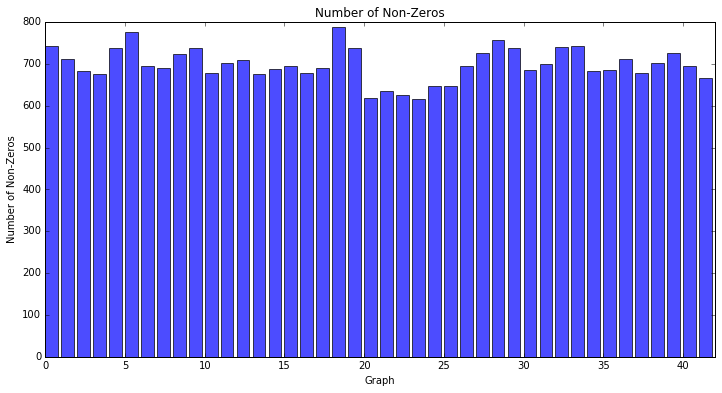

In [6]:
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(nnz)),nnz.values(), alpha=0.7)
plt.title('Number of Non-Zeros')
plt.ylabel('Number of Non-Zeros')
plt.xlabel('Graph')
plt.xlim((0, len(nnz.keys())))
plt.show()

#### Vertex Degree

In [7]:
degrees = collections.OrderedDict((key, np.array(nx.degree(mygs[key]).values())) for key in mygs)

avg_degrees = [np.mean(degrees[key]) for key in degrees]

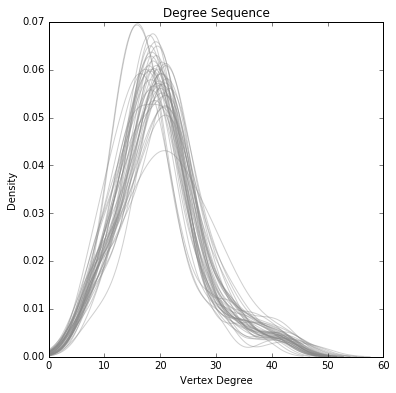

In [8]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in degrees.keys():
    dens = gaussian_kde(degrees[key])
    x = np.linspace(0, 1.2*np.max(degrees[key]), 1000)
    plt.plot(x, dens.pdf(x), color='#888888', alpha=0.4)
plt.title('Degree Sequence')
plt.ylabel('Density')
plt.xlabel('Vertex Degree')
plt.show()

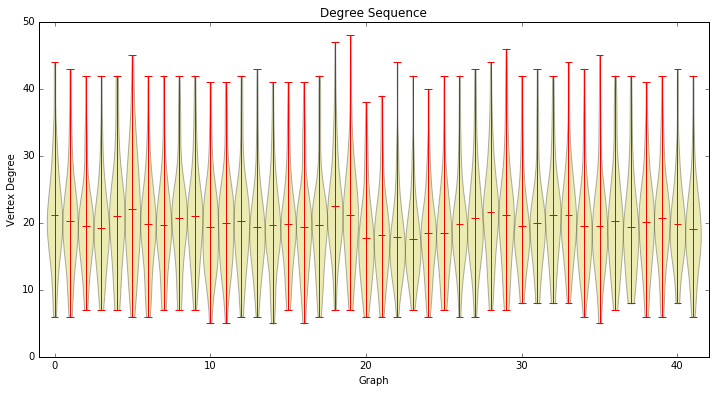

In [9]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(degrees.values(), range(len(degrees)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Degree Sequence')
plt.ylabel('Vertex Degree')
plt.xlabel('Graph')
plt.xlim((-1, len(degrees.keys())))
plt.ylim((0, 50))
plt.show()

#### Edge weight

In [10]:
e_weights = collections.OrderedDict((key, [mygs[key].get_edge_data(e[0],e[1])['weight']
             for e in mygs[key].edges()]) for key in mygs)
avg_e_weights = [{'N': len(e_weights[key]),
                  'mean':np.mean(e_weights[key]),
                  'std':np.std(e_weights[key])} for key in e_weights]

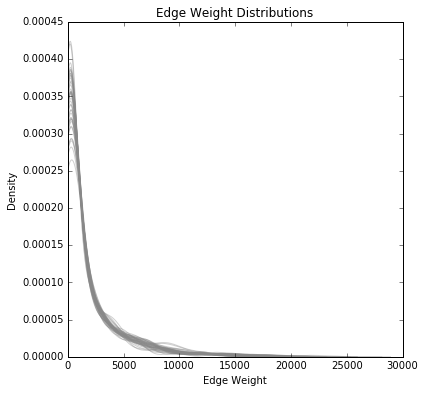

In [11]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in e_weights.keys():
    dens = gaussian_kde(e_weights[key])
    x = np.linspace(0, 1.2*np.max(e_weights[key]), 1000)
    plt.plot(x, dens.pdf(x), color='#888888', alpha=0.4)
plt.title('Edge Weight Distributions')
plt.ylabel('Density')
plt.xlabel('Edge Weight')
plt.show()

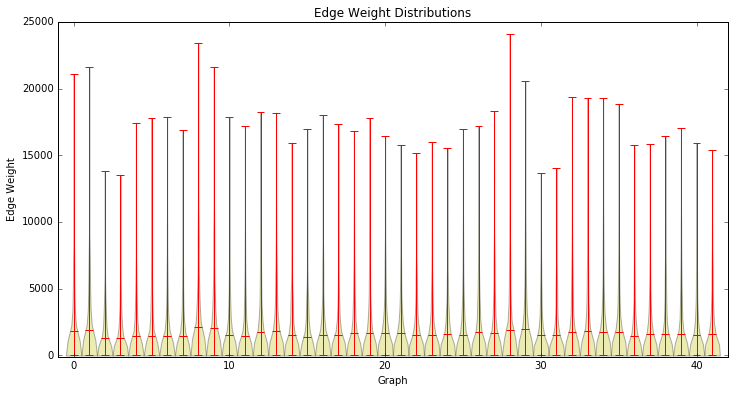

In [12]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(e_weights.values(), range(len(e_weights)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Edge Weight Distributions')
plt.ylabel('Edge Weight')
plt.xlabel('Graph')
plt.xlim((-1, len(e_weights.keys())))
plt.ylim((-100, 25000))
plt.show()

#### Edge count

In [13]:
e_count = collections.OrderedDict((key, len(e_weights[key])) for key in e_weights)

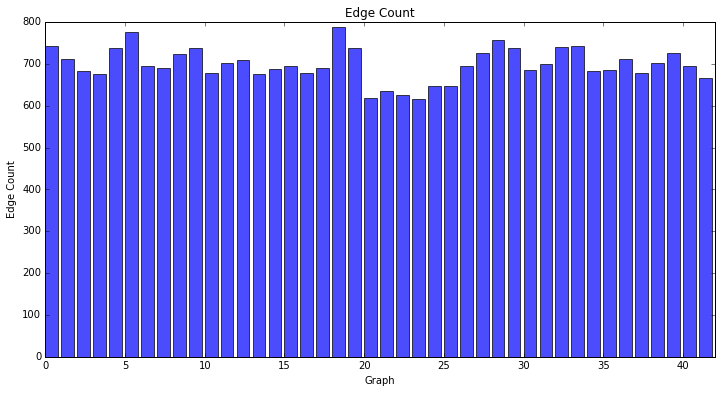

In [14]:
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(e_count)),e_count.values(), alpha=0.7)
plt.title('Edge Count')
plt.ylabel('Edge Count')
plt.xlabel('Graph')
plt.xlim((0, len(e_count.keys())))
plt.show()

#### Number of Local 3-cliques

In [15]:
three_cliques = collections.OrderedDict((key, [clique for clique in
                       nx.algorithms.clique.enumerate_all_cliques(mygs[key])
                       if len(clique) == 3]) for key in mygs)
n_three_cliques = [len(three_cliques[key]) for key in three_cliques]

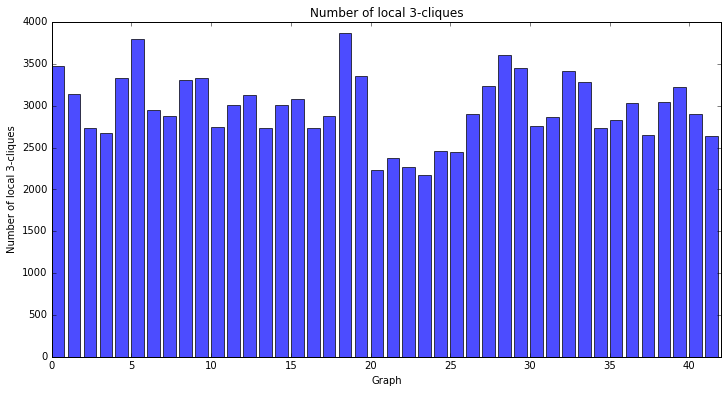

In [16]:
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(n_three_cliques)),n_three_cliques, alpha=0.7)
plt.title('Number of local 3-cliques')
plt.ylabel('Number of local 3-cliques')
plt.xlabel('Graph')
plt.xlim((0, len(three_cliques.keys())))
plt.show()

#### Clustering Coefficient

In [17]:
ccoefs = collections.OrderedDict((key, nx.clustering(mygs[key]).values()) for key in mygs)
avg_ccoefs = [np.mean(ccoefs[key]) for key in ccoefs]

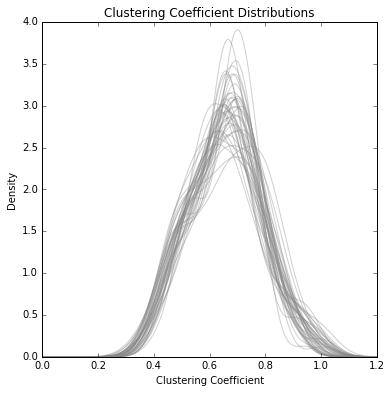

In [18]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in ccoefs.keys():
    dens = gaussian_kde(ccoefs[key])
    x = np.linspace(0, 1.2*np.max(ccoefs[key]), 1000)
    plt.plot(x, dens.pdf(x), color='#888888', alpha=0.4)
plt.title('Clustering Coefficient Distributions')
plt.ylabel('Density')
plt.xlabel('Clustering Coefficient')
plt.show()

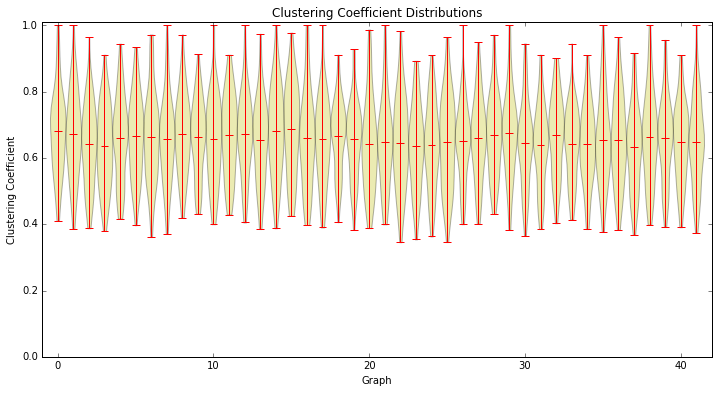

In [19]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(ccoefs.values(), range(len(ccoefs)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Clustering Coefficient Distributions')
plt.ylabel('Clustering Coefficient')
plt.xlabel('Graph')
plt.xlim((-1, len(ccoefs.keys())))
plt.ylim((0, 1.01))
plt.show()

#### Scan Statistic-i

In [20]:
i = 1
def scan_statistic(mygs, i):
    ss = collections.OrderedDict()
    for key in mygs.keys():
        g = mygs[key]
        tmp = np.array(())
        for n in g.nodes():
            subgraph = nx.ego_graph(g, n, radius = i)
            tmp = np.append(tmp, np.sum([subgraph.get_edge_data(e[0],e[1])['weight'] for e in subgraph.edges()]))
        ss[key] = tmp
    return ss

ss1 = scan_statistic(mygs, i)

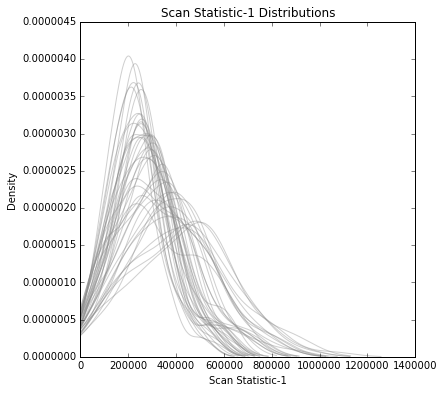

In [21]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in ss1.keys():
    dens = gaussian_kde(ss1[key])
    x = np.linspace(0, 1.2*np.max(ss1[key]), 1000)
    plt.plot(x, dens.pdf(x), color='#888888', alpha=0.4)
plt.title('Scan Statistic-1 Distributions')
plt.ylabel('Density')
plt.xlabel('Scan Statistic-1')
plt.show()

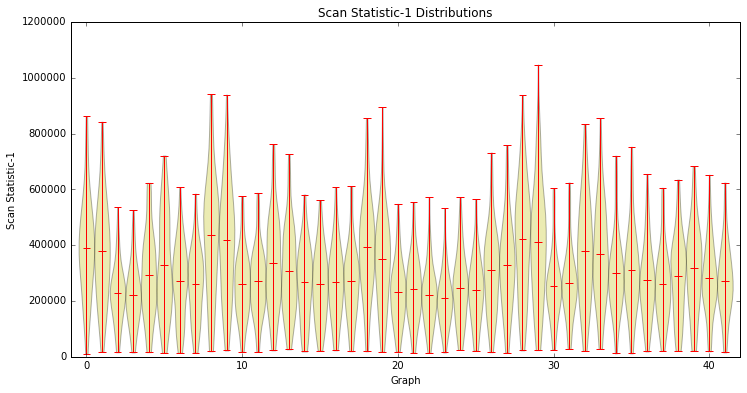

In [22]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(ss1.values(), range(len(ss1)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Scan Statistic-1 Distributions')
plt.ylabel('Scan Statistic-1')
plt.xlabel('Graph')
plt.xlim((-1, len(ss1.keys())))
plt.show()

In [23]:
i = 2
ss2 = scan_statistic(mygs, i)

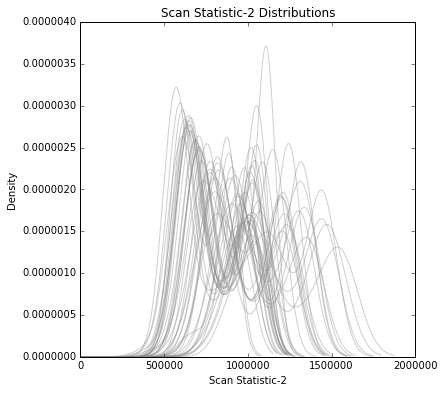

In [24]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in ss2.keys():
    dens = gaussian_kde(ss2[key])
    x = np.linspace(0, 1.2*np.max(ss2[key]), 1000)
    plt.plot(x, dens.pdf(x), color='#888888', alpha=0.4)
plt.title('Scan Statistic-2 Distributions')
plt.ylabel('Density')
plt.xlabel('Scan Statistic-2')
plt.show()

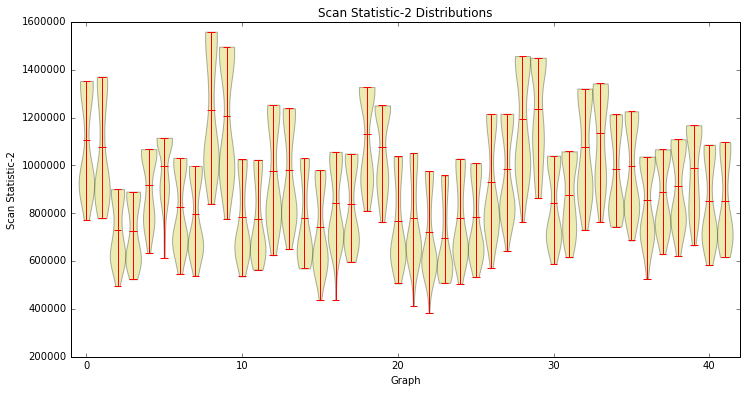

In [25]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(ss2.values(), range(len(ss2)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Scan Statistic-2 Distributions')
plt.ylabel('Scan Statistic-2')
plt.xlabel('Graph')
plt.xlim((-1, len(ss2.keys())))
plt.show()

#### Eigen value

In [26]:
laplacian = collections.OrderedDict((key, nx.normalized_laplacian_matrix(mygs[key])) for key in mygs)
eigs = collections.OrderedDict((key, np.sort(np.linalg.eigvals(laplacian[key].A))[::-1]) for key in laplacian)

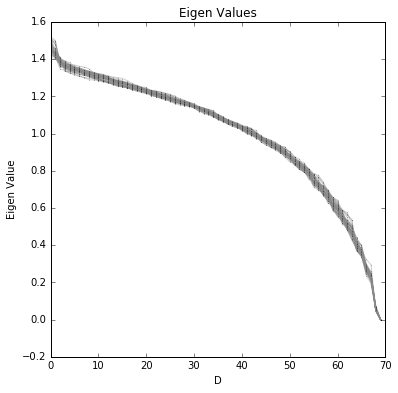

In [27]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in eigs.keys():
#     dens = gaussian_kde(eigs[key])
#     x = np.linspace(0, 1.2*np.max(eigs[key]), 1000)
    plt.plot(eigs[key], 'ro-', markersize=0.4, color='#888888', alpha=0.4)
plt.title('Eigen Values')
plt.ylabel('Eigen Value')
plt.xlabel('D')
plt.show()

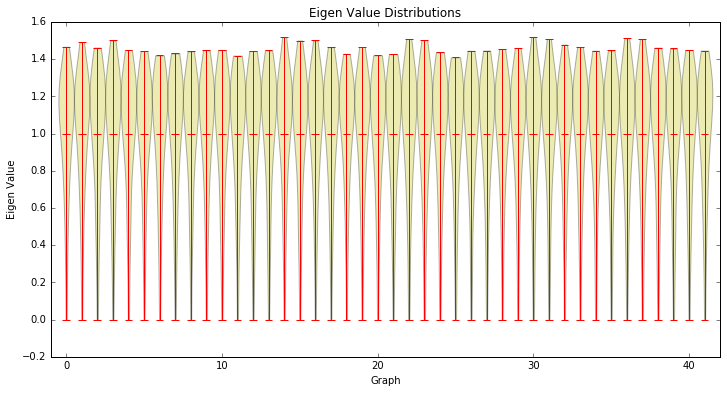

In [28]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(eigs.values(), range(len(eigs)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Eigen Value Distributions')
plt.ylabel('Eigen Value')
plt.xlabel('Graph')
plt.xlim((-1, len(eigs.keys())))
plt.show()

#### Betweenness Centrality

In [29]:
centrality = collections.OrderedDict((key, nx.algorithms.betweenness_centrality(mygs[key]).values())
                                     for key in mygs.keys())

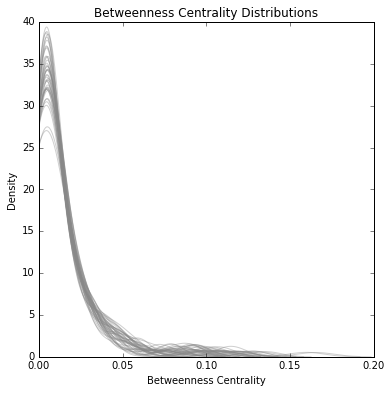

In [30]:
fig = plt.figure(figsize=(6,6))
plt.hold(True)
for key in centrality.keys():
    dens = gaussian_kde(centrality[key])
    x = np.linspace(0, 1.2*np.max(centrality[key]), 1000)
    plt.plot(x, dens.pdf(x), color='#888888', alpha=0.4)
plt.title('Betweenness Centrality Distributions')
plt.ylabel('Density')
plt.xlabel('Betweenness Centrality')
plt.show()

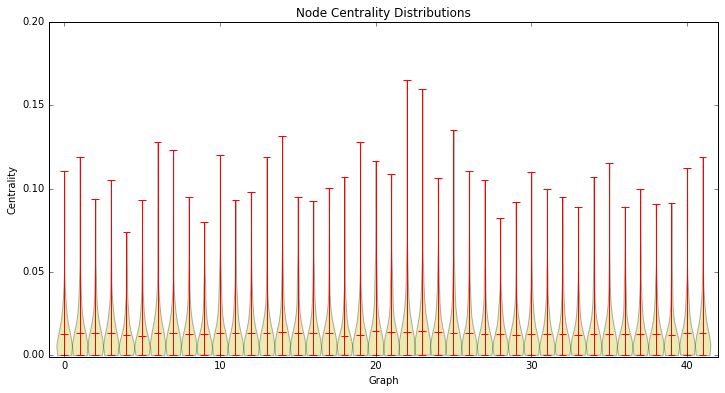

In [31]:
fig = plt.figure(figsize=(12,6))
plt.violinplot(centrality.values(), range(len(e_weights)), points=20, widths=1, showmeans=True, showextrema=True)
plt.title('Node Centrality Distributions')
plt.ylabel('Centrality')
plt.xlabel('Graph')
plt.xlim((-1, len(centrality.keys())))
plt.ylim((-0.001, .2 ))
plt.show()

#### Connected Compontent (abandonning for now)

In [25]:
ccs = {keys: nx.connected_component_subgraphs(mygs[keys]) for keys in mygs.keys()}
# nccs = {keys: len(list(ccs[keys])) for keys in ccs.keys()}
# print nccs
lccs = {keys: max(ccs[keys], key=len) for keys in ccs.keys()}